<h1 style="text-align: center; margin-top: 200px; font-size: 48px;">
  Maven Roasters 카페 일별 매출 예측
</h1>

<p style="position: absolute; bottom: 20px; right: 40px; font-size: 20px;">
  이름: 김태수<br>
  학번: 202016219
</p>

<div style="page-break-after: always;"></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel("Maven Roasters.xlsx")

In [3]:
df['sales'] = df['transaction_qty'] * df['unit_price']

In [4]:
daily_sales = df.pivot_table(index='transaction_date',values='sales',aggfunc='sum').reset_index()

In [5]:
df = df.merge(daily_sales, on='transaction_date', how='left').rename({'sales_y':'daily_sales'},axis=1).drop('sales_x',axis=1)

In [6]:
df = df.drop('transaction_time',axis=1)

### 데이터 크기

- 관측치 149,116개

- 변수 11개

### 사용된 변수

- transaction_id : 각 거래의 고유 ID (일련번호)

- transaction_date : 거래 날짜 (MM/DD/YY)

- transaction_qty : 거래된 수량 (몇 개 팔렸는지)

- store_id : 매장의 고유 ID (예: S1, S2 등)

- store_location : 매장 위치 (예: Manhattan, Brooklyn 등)

- product_id : 제품 고유 ID

- unit_price : 제품 1개의 가격

- product_category : 제품 카테고리 (예: Beverage, Food 등)

- product_type : 제품 종류 (예: Coffee, Tea, Sandwich 등)

- product_detail : 세부 제품 이름 (예: Iced Vanilla Latte 등)

- daily_sales : 일별 매출 (반응변수)

<div style="page-break-before: always;"></div>

### 기본 데이터 구조

In [7]:
df.head()

,transaction_id,transaction_date,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,daily_sales
0,1,2023-01-01,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2508.2
1,2,2023-01-01,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2508.2
2,3,2023-01-01,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,2508.2
3,4,2023-01-01,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2508.2
4,5,2023-01-01,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2508.2


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_qty   149116 non-null  int64         
 3   store_id          149116 non-null  int64         
 4   store_location    149116 non-null  object        
 5   product_id        149116 non-null  int64         
 6   unit_price        149116 non-null  float64       
 7   product_category  149116 non-null  object        
 8   product_type      149116 non-null  object        
 9   product_detail    149116 non-null  object        
 10  daily_sales       149116 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 12.5+ MB
None


<div style="page-break-before: always;"></div>

### 반응변수 분포

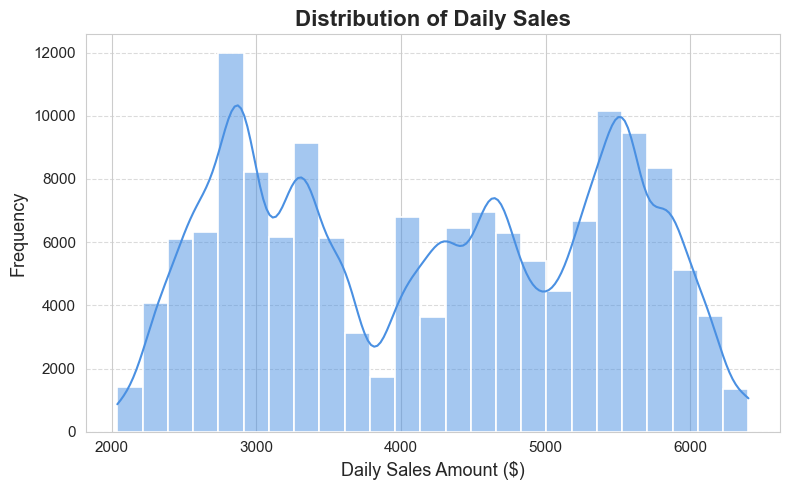

In [60]:
plt.figure(figsize=(8,5))
sns.set_style('whitegrid')

sns.histplot(
    data=df, 
    x='daily_sales', 
    bins=25, 
    kde=True, 
    color="#4A90E2",
    edgecolor='white',
    linewidth=1.2
)

plt.title('Distribution of Daily Sales', fontsize=16, fontweight='bold')
plt.xlabel('Daily Sales Amount ($)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- daily_sales는 대체로 2000~6000달러 사이에 분포하며, 중앙값 부근인 약 4000달러 근처에서 빈도가 다소 감소하는 경향이 관찰된다.
- 이는 히스토그램 상에서도 중심부가 평탄하지 않고 살짝 패여 있는 형태로 나타난다.

### 기초통계량

In [10]:
df['daily_sales'].describe()

count    149116.000000
mean       4209.175173
std        1202.722643
min        2037.100000
25%        3040.250000
50%        4265.450000
75%        5370.810000
max        6403.910000
Name: daily_sales, dtype: float64

- daily_sales의 평균은 약 4209.18, 중앙값은 4265.45로 양자의 차이가 약 56.27에 불과하여 분포는 대체로 대칭적인 형태로 보인다.
- 또한 표준편차는 약 1202.72로, 평균 대비 약 28.6% 수준으로 분산도 과도하지 않아 데이터의 산포도 비교적 안정적인 편이다.

<div style="page-break-before: always;"></div>

### 이상치

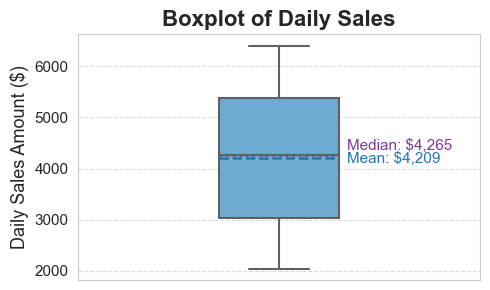

In [61]:
plt.figure(figsize=(5,3))
sns.set_style("whitegrid")

sns.boxplot(
    y='daily_sales', 
    data=df,
    width=0.3,
    color='#5DADE2',
    fliersize=3,
    linewidth=1.5
)

mean_val = df['daily_sales'].mean()
median_val = df['daily_sales'].median()

plt.axhline(y=mean_val, xmin=0.35, xmax=0.65, color='#1F77B4', linestyle='--', linewidth=1.8)
plt.axhline(y=median_val, xmin=0.35, xmax=0.65, color='#7D3C98', linestyle=':', linewidth=1.8)

plt.text(x=0.17, y=mean_val-100, s=f'Mean: ${mean_val:,.0f}', color='#1F77B4', fontsize=11)
plt.text(x=0.17, y=median_val+100, s=f'Median: ${median_val:,.0f}', color='#7D3C98', fontsize=11)

plt.title('Boxplot of Daily Sales', fontsize=16, fontweight='bold')
plt.ylabel('Daily Sales Amount ($)', fontsize=13)
plt.xlabel('')

plt.yticks(fontsize=11)
plt.xticks([])

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- 박스플롯을 활용한 IQR(Interquartile Range) 기반 탐지 결과, 대부분의 관측값이 1.5×IQR 범위 내에 분포하고 있으며, 극단적인 이상치는 발견되지 않았다.

### 일별 매출액

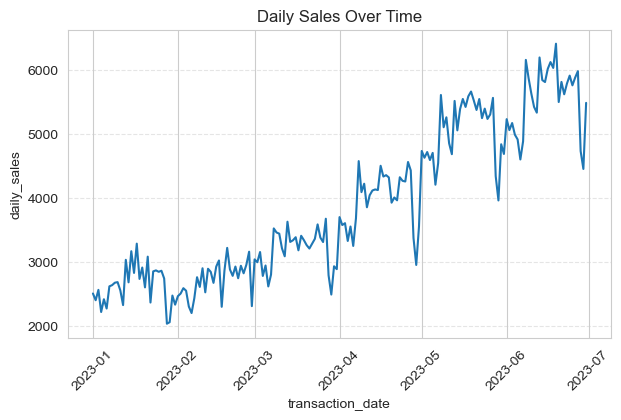

In [62]:
df_daily = df[['transaction_date', 'daily_sales']].drop_duplicates().sort_values('transaction_date')
plt.figure(figsize=(7,4))
sns.lineplot(data=df_daily, x='transaction_date', y='daily_sales')
plt.title('Daily Sales Over Time')
plt.xticks(rotation=45)
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
plt.show()

- 전체적으로 시간 경과에 따라 daily_sales가 점진적으로 증가하는 추세를 보인다.
- 월별 매출 흐름을 보면, 매월 초에는 매출이 상대적으로 증가하는 반면, 월말에는 점차 감소하는 경향이 반복적으로 나타나므로 월 단위 주기성을 가지는 것 같다.

<div style="page-break-before: always;"></div>

### 지점별 매출액

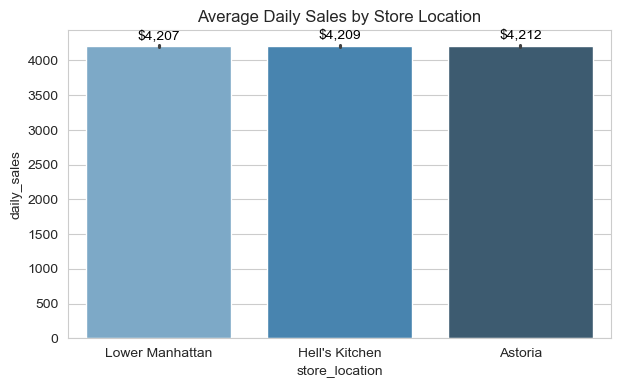

In [13]:
df_avg = df.groupby('store_location')['daily_sales'].mean().reset_index()
df_avg = df_avg.sort_values('daily_sales', ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(data=df, x='store_location', y='daily_sales',hue='store_location', palette='Blues_d')

for i, row in df_avg.iterrows():
    plt.text(
        x=i,
        y=row['daily_sales'] + 50,
        s=f"${row['daily_sales']:,.0f}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.title('Average Daily Sales by Store Location')
plt.show()

- 지점별 daily_sales 분포를 비교한 결과 전체적으로 유사한 범위내에 분포되어 있어 지점 간 매출 차이는 유의하다고 볼 수 없다.

### 제품 카테고리별 매출액

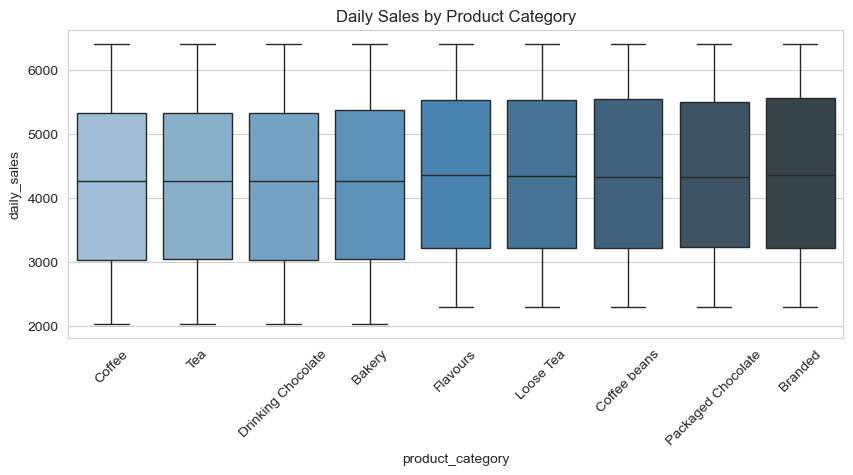

In [14]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df, x='product_category', y='daily_sales', hue='product_category', palette='Blues_d')
plt.xticks(rotation=45)
plt.title('Daily Sales by Product Category')
plt.show()

- product_category별로 daily_sales의 분포를 비교한 결과, 각 그룹 간 평균 매출액 차이가 미미하고 분산 또한 유사하게 나타난다.

<div style="page-break-before: always;"></div>

### 상관계수 Heatmap

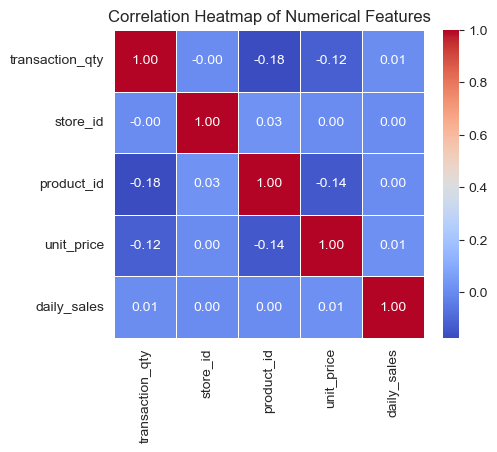

In [63]:
num_df = df.select_dtypes(include=['float64', 'int64']).drop(['transaction_id'],axis=1)
corr_matrix = num_df.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

- 수치형 변수 간 상관관계를 살펴본 결과 반응변수인 daily_sales와 다른 변수들 간의 상관계수는 모두 0.1 이하로 매우 낮아 강한 선형적 연관성은 확인되지 않는다.

### 전처리

In [16]:
df['year'] = df['transaction_date'].dt.year
df['day'] = df['transaction_date'].dt.day
df['dayofweek'] = df['transaction_date'].dt.dayofweek

In [17]:
X = df.drop(['transaction_id','transaction_date','daily_sales'],axis=1)
y = df['daily_sales']

In [18]:
X = pd.get_dummies(X,drop_first=True)

- transaction_date는 날짜형 변수로서 회귀모형에 직접 입력하기 적절하지 않기 때문에, 연(year), 일(day), 요일(dayofweek) 의 파생변수로 분해하여 사용하였다.
- transaction_id는 단순히 각 거래를 구분하기 위한 식별자 역할만 하므로 예측에 기여할 정보가 없어 분석에서 제외하였다.
- 또한 범주형 변수는 회귀모형에서 활용할 수 있도록 원핫인코딩 방식으로 변환하였다.

### 데이터 분할

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2025)

- 데이터는 훈련용 70%, 평가용 30%로 분할하여 모델 학습 및 성능 평가에 활용하였다.

<div style="page-break-before: always;"></div>

### 회귀모형

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [21]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred1 = model1.predict(X_test)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred1))
print(f"[Linear Regression] RMSE: {rmse1:.2f}")

[Linear Regression] RMSE: 1194.48


- 선형 회귀는 종속 변수와 독립 변수 간의 선형 관계를 가정하는 가장 기본적인 예측 모델로, 모든 설명변수를 그대로 사용하여 학습하였다.
- 범주형 변수는 원핫인코딩 처리되었으며, 날짜 변수는 연, 일, 요일로 파생된 후 인코딩되었다.
- 데이터는 훈련 70%, 테스트 30%로 분할하여 학습하였고, 예측 성능 평가는 RMSE를 기준으로 진행하였다. 
- 선형 회귀 결과, 테스트 데이터에 대한 RMSE는 1194.48이였다.
- 이는 선형 모델이 비선형 패턴을 충분히 포착하지 못했기 때문일 수 있으며, 이후 더 복잡한 모델에서 성능 향상을 기대할 수 있다.

### RIDGE

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
alphas = [0.01, 0.1, 1, 10, 100]

In [26]:
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [27]:
best_ridge = grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)

In [28]:
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE: {rmse_ridge:.2f}")

RMSE: 1194.48


- Ridge 회귀는 선형 회귀에 L2 정규화 항을 추가하여 계수의 크기를 제한함으로써 과적합을 방지하는 모델이다.
- 설명변수들은 StandardScaler를 사용하여 정규화하였고, GridSearchCV를 통해 alpha 값에 대해 5-fold 교차검증을 수행한 결과, 최적의 alpha는 100으로 선택되었다.
- 데이터는 훈련 70%, 테스트 30%로 분할하여 학습하였고, 예측 성능 평가는 RMSE를 기준으로 진행하였다. 
- 테스트 데이터에 대한 RMSE는 1194.48으로, 일반 선형 회귀와 유사한 수준의 예측 성능을 나타냈다.

<div style="page-break-before: always;"></div>

### LASSO

In [29]:
from sklearn.linear_model import Lasso

In [30]:
lasso = Lasso(max_iter=10000, tol=0.01)
alphas = [0.001, 0.01, 0.1, 1]
grid = GridSearchCV(
    lasso,
    param_grid={'alpha': alphas},
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, tol=0.01), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [31]:
best_lasso = grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

In [32]:
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE: {rmse_lasso:.2f}")

RMSE: 1194.39


- Lasso 회귀는 선형 회귀에 L1 정규화 항을 추가하여 일부 계수를 0으로 만들 수 있어, 자동 변수 선택 효과를 가지는 모델이다.
- 설명변수들은 StandardScaler를 사용하여 정규화하였고, GridSearchCV를 통해 alpha 값에 대해 5-fold 교차검증을 수행한 결과, 최적의 alpha는 1로 선택되었다.
- 데이터는 훈련 70%, 테스트 30%로 분할하여 학습하였고, 예측 성능 평가는 RMSE를 기준으로 진행하였다. 
- 테스트 데이터에 대한 RMSE는 1194.39로, 선형 회귀 및 Ridge 회귀와 유사한 수준의 예측 성능을 나타냈다.

### GAM

In [33]:
from pygam import LinearGAM, s, f

In [34]:
gam = LinearGAM(n_splines=10).fit(X_train, y_train)
y_pred_gam = gam.predict(X_test)

In [35]:
rmse_gam = np.sqrt(mean_squared_error(y_test, y_pred_gam))
print(f"[GAM] RMSE: {rmse_gam:.2f}")

[GAM] RMSE: 1165.19


- GAM(Generalized Additive Model)은 선형 회귀의 확장된 형태로, 각 설명변수에 대해 개별적으로 비선형 함수를 적용함으로써 더 유연한 예측이 가능하도록 한다.
- pygam 라이브러리를 사용하여 LinearGAM 모델을 구성하였으며, 기존 전처리된 설명변수를 그대로 입력하여 학습을 수행하였다.
- 데이터는 훈련 70%, 테스트 30%로 분할하여 학습하였고, 예측 성능 평가는 RMSE를 기준으로 진행하였다. 
- 테스트 데이터에 대한 RMSE는 1165.19으로, 기존 모델들보다 약간 향상된 예측 성능을 나타냈다.

<div style="page-break-before: always;"></div>

### 나무모형

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
tree = DecisionTreeRegressor(random_state=1)

In [38]:
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [39]:
grid = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [40]:
best_tree = grid.best_estimator_
y_pred_tree = best_tree.predict(X_test)

In [41]:
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print(f"RMSE: {rmse_tree:.2f}")

RMSE: 137.57


- 의사결정나무는 데이터를 조건에 따라 분할하면서 예측값을 생성하는 비선형 모델로, 변수 간 상호작용과 비선형 구조를 자동으로 포착할 수 있는 장점이 있다.
- GridSearchCV를 이용해 max_depth와 min_samples_split을 최적화한 결과, 최적 파라미터는 max_depth=15, min_samples_split=10으로 선택되었다.
- 데이터는 훈련 70%, 테스트 30%로 분할하여 학습하였고, 예측 성능 평가는 RMSE를 기준으로 진행하였다. 
- 테스트 데이터에 대한 RMSE는 137.57로, 기존 모델들보다 현저히 향상된 예측 성능을 나타냈다.

### 부스팅

In [42]:
import xgboost as xgb

In [43]:
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

In [44]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5]
}

In [45]:
grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [46]:
best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

In [47]:
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE: {rmse_xgb:.2f}")

RMSE: 136.33


- XGBoost 모형은 여러 약한 결정나무를 순차적으로 학습하며 잔차를 보정하는 부스팅 앙상블 방식으로, 복잡한 변수 간 상호작용과 비선형성을 효과적으로 포착한다.
- GridSearchCV를 통해 max_depth=7, learning_rate=0.2, n_estimators=200, min_child_weight=5의 최적 파라미터를 도출하였다.
- 데이터는 훈련 70%, 테스트 30%로 분할하여 학습하였고, 예측 성능 평가는 RMSE를 기준으로 진행하였다. 
- 테스트 데이터 RMSE는 136.33으로 의사결정나무보다 성능이 약간 향상되었다.

<div style="page-break-before: always;"></div>

### 성능비교

In [48]:
models = ['Linear', 'Ridge', 'Lasso', 'GAM', 'Tree', 'XGBoost']
rmses = [1194.48, 1194.48, 1194.39, 1165.19, 137.57, 136.33]

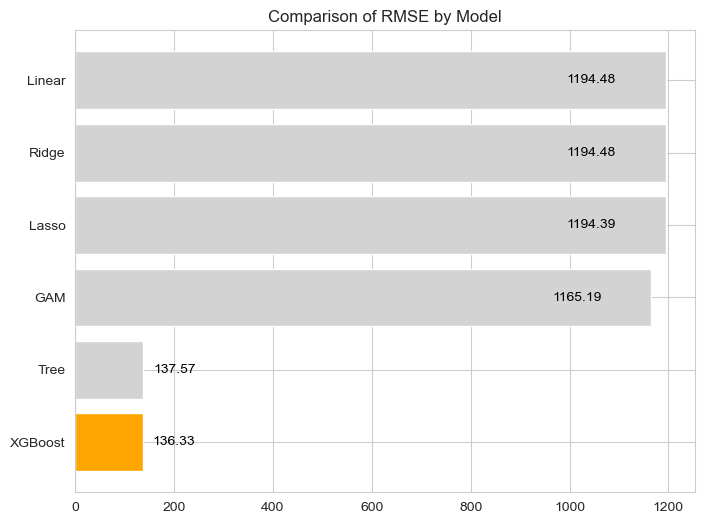

In [64]:
plt.figure(figsize=(8, 6))
bars=plt.barh(models, rmses, color=['lightgray','lightgray','lightgray','lightgray','lightgray','orange'])

for model, bar, rmse in zip(models, bars, rmses):
    width = bar.get_width()
    if model in ['Tree', 'XGBoost']:
        plt.text(width + 20, bar.get_y() + bar.get_height() / 2,
                 f"{rmse:.2f}", va='center', ha='left', color='black', fontsize=10)
    else:
        plt.text(width - 100, bar.get_y() + bar.get_height() / 2,
                 f"{rmse:.2f}", va='center', ha='right', color='black', fontsize=10)

plt.title("Comparison of RMSE by Model")
plt.gca().invert_yaxis()
plt.show()

- 선형모형 계열에서는 모두 RMSE가 1194 내외로 유사한 수준이었으나, 이는 데이터가 선형모형으로는 잘 설명되지 않음을 의미한다.
- 반면, 트리 기반 모델은 변수 간 상호작용 및 비선형 분포를 효과적으로 포착함으로써 RMSE를 137 수준까지 낮추었고, XGBoost는 여기에 더해 오차 보정을 통해 가장 우수한 성능을 기록하였다.

<div style="page-break-before: always;"></div>

### 변수 중요도

In [50]:
importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

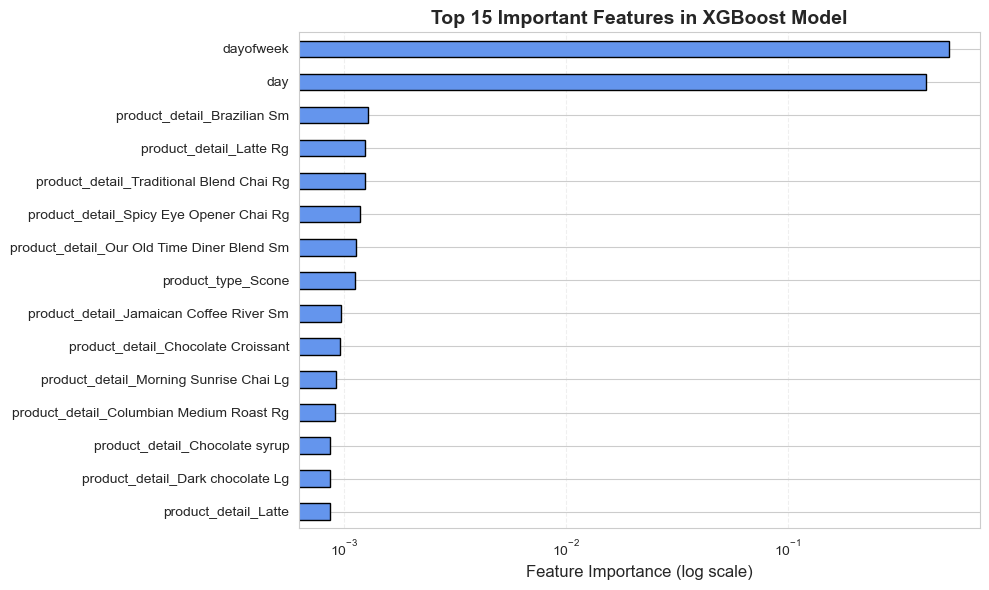

In [65]:
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='cornflowerblue', edgecolor='black')

plt.xlabel("Feature Importance (log scale)", fontsize=12)
plt.title("Top 15 Important Features in XGBoost Model", fontsize=14, fontweight='bold')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

- 최적의 모형으로 뽑힌 XGBoost에서 어떠한 변수가 크게 중요한지 살펴보았을 때 거래 요일에 해당하는 dayofweek와 거래일에 해당하는 day의 중요도가 가장 높게 나왔다.
- 이는 특정 요일이나 날짜에 따라 매출액이 크게 달라지며 고객 행동 패턴(예: 주말에 더 붐빔, 평일은 한산함 등)을 반영한 결과로 받아들일 수 있다.